# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: driven damped pendulum

Consider a single pendulum with angle $\theta(t)$ and input $u(t)$ evolving according to:

$$ \ddot{\theta} + \frac{\mathcal{g}}{l} \sin(\theta) + \frac{\gamma}{l} \dot{\theta} = \frac{1}{ml} u\, .$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

In [2]:
using Revise
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("../Pendulums.jl"); using .Pendulums

In [151]:
# System parameters
sys_mass = 2.0
sys_length = 0.5
sys_damping = 0.2
sys_mnoise_sd = 1e-2
sys_ulims = (-40., 40.)
Δt = 0.2

init_state = [0.0, 0.0]
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

SPendulum([0.0, 0.0], 0.0020463030833214437, 0.0, (-40.0, 40.0), 0.2, 2.0, 0.5, 0.2, 0.01)

In [125]:
N = 100
tsteps = range(0.0, step=Δt, length=N)

0.0:0.2:19.8

In [126]:
# Inputs
A  = rand(10)*300 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10]) ./ 10;

In [127]:
states = zeros(2,N)
observations = zeros(N)
torques = zeros(N)

for k in 1:N
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    step!(pendulum, controls[k])
    torques[k] = pendulum.torque
end

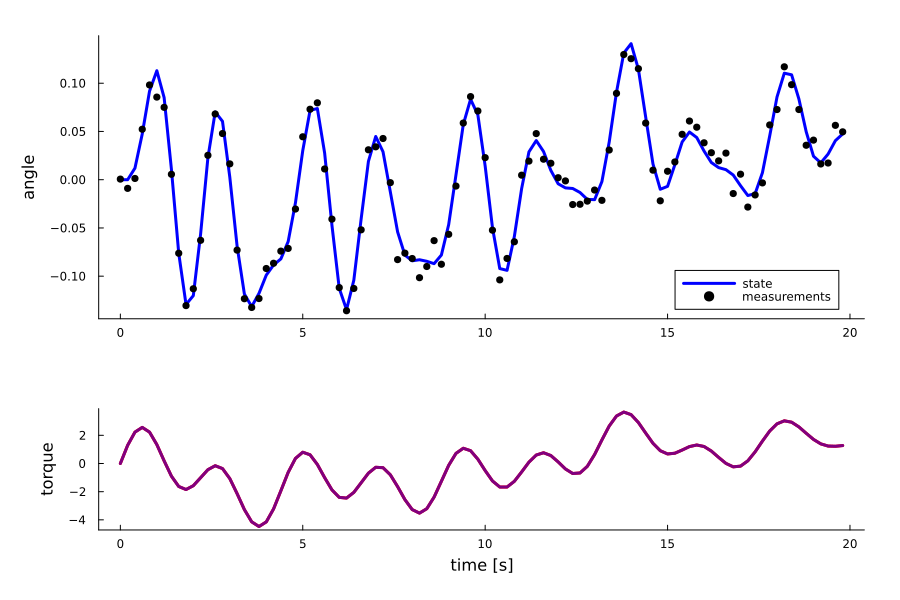

In [128]:
p1 = plot(ylabel="angle")
plot!(tsteps, states[1,:], color="blue", label="state")
scatter!(tsteps, observations, color="black", label="measurements")
p2 = plot(xlabel="time [s]", ylabel="torque")
plot!(tsteps, controls[:], color="red")
plot!(tsteps, torques[:], color="purple")
plot(p1,p2, layout=grid(2,1, heights=[0.7, 0.3]), size=(900,600))

## Test model

In [129]:
# NARX settings
H = 2
Ly = 2
Lu = 2
M = size(pol(zeros(Ly+Lu+1), degree=H),1);

# Specify prior distributions
α0 = 10.0
β0 = 1.0
μ0 = zeros(M)
Λ0 = diagm(ones(M))
goal = Normal(3.14, 1.0)

T = 15

agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T)

NARXAgent([0.0, 0.0], [0.0, 0.0, 0.0], 2, 2, 2, 11, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], 10.0, 1.0, 0.0, Normal{Float64}(μ=3.14, σ=1.0), 15, 10, Inf)

In [130]:
py = []
μ = [μ0]
Λ = [Λ0]
α = [α0]
β = [β0]
FE = zeros(N)

torques_ = [torques; zeros(T)]
@showprogress for k in 1:N
    
    # Make predictions
    push!(py, predictions(agent, torques_[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, observations[k], torques[k])
    push!( μ, agent.μ )
    push!( Λ, agent.Λ )
    push!( α, agent.α )
    push!( β, agent.β )
    FE[k] = agent.free_energy
    
end

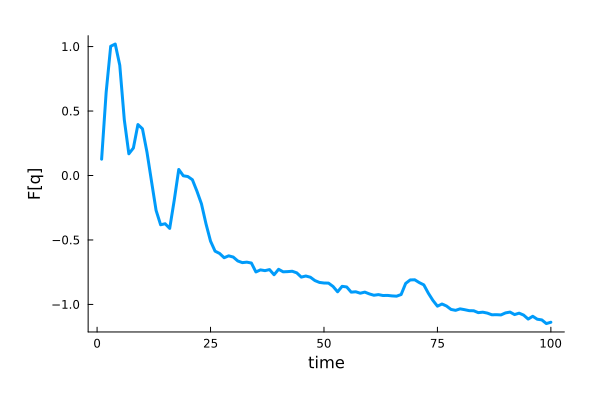

In [131]:
plot(FE, xlabel="time", ylabel="F[q]")

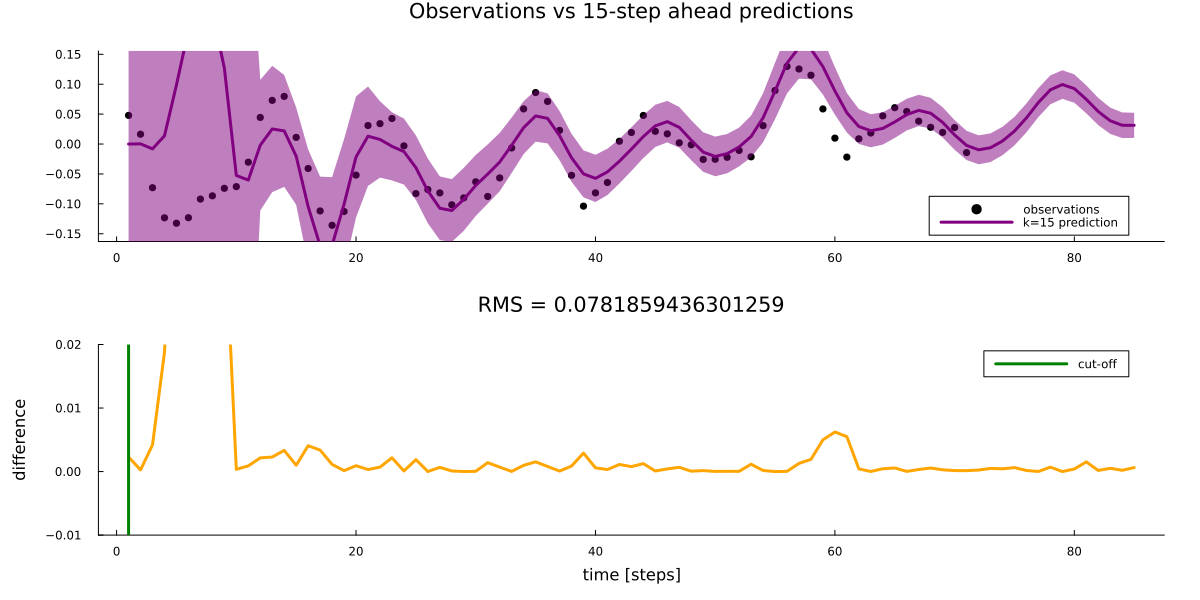

In [132]:
limsb = [minimum(observations)*1.2, maximum(observations)*1.2]
K = 15

residuals = (observations[K:K+(N-T)-1] .- [py[k][1][K] for k in 1:(N-T)]).^2
cutoff = 1
RMS = sqrt(mean((residuals[cutoff:end])))

p1 = plot(title="Observations vs $K-step ahead predictions", ylims=limsb)
scatter!(observations[K:N-T], color="black", label="observations")
plot!([py[k][1][K] for k in 1:(N-T)], ribbon=[py[k][2][K] for k in 1:(N-T)], color="purple", label="k=$K prediction")
p2 = plot(xlabel="time [steps]", ylims=(-0.01, 0.02))
plot!(residuals, title="RMS = $RMS", color="orange", ylabel="difference")
vline!([cutoff], color="green", label="cut-off")
plot(p1,p2,layout=grid(2,1), size=(1200,600),)

## Experiments

In [153]:
# Experiment specification 
N = 200
tsteps = range(0.0, step=Δt, length=N)
T = 10

# System specification
init_state = [0.0, 0.0];

# Agent specification
α0 = 10.0
β0 = 1.0
μ0 = zeros(M)
Λ0 = diagm(ones(M))
λ = 1e-3

0.001

### Expected Free Energy minimization

In [154]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

goals = [Normal(3.14, 1.0) for t in 1:T]
cut_gvar = tsteps[N]
new_gvar = 1.0
# gvars = [1e3 for k in 1:N]

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T)

# Preallocate
y_EFE = zeros(N)
z_EFE = zeros(2,N)
u_EFE = zeros(N+T)
μ_EFE = [μ0]
Λ_EFE = [Λ0]
α_EFE = [α0]
β_EFE = [β0]
F_EFE = zeros(N)
pred_m = zeros(N,T)
pred_v = zeros(N,T)

@showprogress for k in 1:N    
    
    # Update parameter beliefs
    y_EFE[k] = pendulum.sensor
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    F_EFE[k] = agent.free_energy
    push!(μ_EFE, agent.μ )
    push!(Λ_EFE, agent.Λ )
    push!(α_EFE, agent.α )
    push!(β_EFE, agent.β )

    # Change exploration-exploitation balance
    if k > cut_gvar; agent.goals = [Normal(3.14, new_gvar) for t in 1:T]; end
    # goal_k = NormalMeanVariance(3.14, gvars[k])
    # update_goals!(goals, goal_k)
    # agent.goals = goals
    
    # Optimal control
    policy = minimizeEFE(agent, goals, control_lims=sys_ulims)
    u_EFE[k+1:k+T] = policy
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)

    # Act upon environment
    step!(pendulum, u_EFE[k+1])
    z_EFE[:,k] = pendulum.state
    
end

Progress:   1%|█                                        |  ETA: 0:02:47

Progress:   3%|██                                       |  ETA: 0:00:58

Progress:   5%|███                                      |  ETA: 0:00:37

Progress:   6%|███                                      |  ETA: 0:00:30

Progress:   8%|████                                     |  ETA: 0:00:26

Progress:  10%|████                                     |  ETA: 0:00:23

Progress:  11%|█████                                    |  ETA: 0:00:20

Progress:  12%|█████                                    |  ETA: 0:00:20

Progress:  12%|██████                                   |  ETA: 0:00:20

Progress:  13%|██████                                   |  ETA: 0:00:21

Progress:  14%|██████                                   |  ETA: 0:00:20

Progress:  14%|██████                                   |  ETA: 0:00:21

Progress:  15%|███████                                  |  ETA: 0:00:22

Progress:  16%|███████                                  |  ETA: 0:01:07

Progress:  16%|███████                                  |  ETA: 0:01:05

Progress:  16%|███████                                  |  ETA: 0:01:04

Progress:  17%|███████                                  |  ETA: 0:01:05

Progress:  18%|████████                                 |  ETA: 0:01:03

Progress:  18%|████████                                 |  ETA: 0:01:02

Progress:  19%|████████                                 |  ETA: 0:00:59

Progress:  20%|████████                                 |  ETA: 0:00:58

Progress:  20%|█████████                                |  ETA: 0:00:57

Progress:  20%|█████████                                |  ETA: 0:00:56

Progress:  22%|██████████                               |  ETA: 0:00:53

Progress:  22%|██████████                               |  ETA: 0:00:52

Progress:  23%|██████████                               |  ETA: 0:00:51

Progress:  27%|████████████                             |  ETA: 0:00:47

Progress:  28%|████████████                             |  ETA: 0:00:46

Progress:  32%|█████████████                            |  ETA: 0:00:39

Progress:  32%|██████████████                           |  ETA: 0:00:39

Progress:  33%|██████████████                           |  ETA: 0:00:37

Progress:  34%|██████████████                           |  ETA: 0:00:37

Progress:  34%|██████████████                           |  ETA: 0:00:36

Progress:  34%|███████████████                          |  ETA: 0:00:36

Progress:  35%|███████████████                          |  ETA: 0:00:35

Progress:  40%|█████████████████                        |  ETA: 0:00:30

Progress:  45%|███████████████████                      |  ETA: 0:00:25

Progress:  46%|████████████████████                     |  ETA: 0:00:24

Progress:  48%|████████████████████                     |  ETA: 0:00:23

Progress:  49%|█████████████████████                    |  ETA: 0:00:22

Progress:  50%|█████████████████████                    |  ETA: 0:00:22

Progress:  51%|█████████████████████                    |  ETA: 0:00:21

Progress:  52%|██████████████████████                   |  ETA: 0:00:21

Progress:  52%|██████████████████████                   |  ETA: 0:00:20

Progress:  54%|███████████████████████                  |  ETA: 0:00:19

Progress:  56%|███████████████████████                  |  ETA: 0:00:18

Progress:  57%|████████████████████████                 |  ETA: 0:00:17

Progress:  58%|████████████████████████                 |  ETA: 0:00:17

Progress:  58%|████████████████████████                 |  ETA: 0:00:16

Progress:  64%|███████████████████████████              |  ETA: 0:00:14

Progress:  65%|███████████████████████████              |  ETA: 0:00:13

Progress:  66%|████████████████████████████             |  ETA: 0:00:12

Progress:  66%|████████████████████████████             |  ETA: 0:00:12

Progress:  68%|████████████████████████████             |  ETA: 0:00:12

Progress:  70%|█████████████████████████████            |  ETA: 0:00:11

Progress:  74%|███████████████████████████████          |  ETA: 0:00:09

Progress:  74%|███████████████████████████████          |  ETA: 0:00:09

Progress:  75%|███████████████████████████████          |  ETA: 0:00:09

Progress:  76%|████████████████████████████████         |  ETA: 0:00:08

Progress:  78%|████████████████████████████████         |  ETA: 0:00:07

Progress:  79%|█████████████████████████████████        |  ETA: 0:00:07

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:07

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:07

Progress:  81%|██████████████████████████████████       |  ETA: 0:00:06

Progress:  82%|██████████████████████████████████       |  ETA: 0:00:06

Progress:  83%|███████████████████████████████████      |  ETA: 0:00:06

Progress:  84%|███████████████████████████████████      |  ETA: 0:00:05

Progress:  85%|███████████████████████████████████      |  ETA: 0:00:05

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:05

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:03

Progress:  91%|██████████████████████████████████████   |  ETA: 0:00:03

Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:02

Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:02

Progress:  98%|█████████████████████████████████████████|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


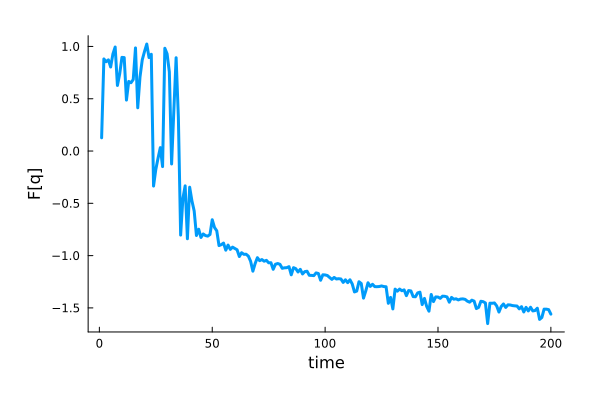

In [155]:
plot(F_EFE, xlabel="time", ylabel="F[q]")

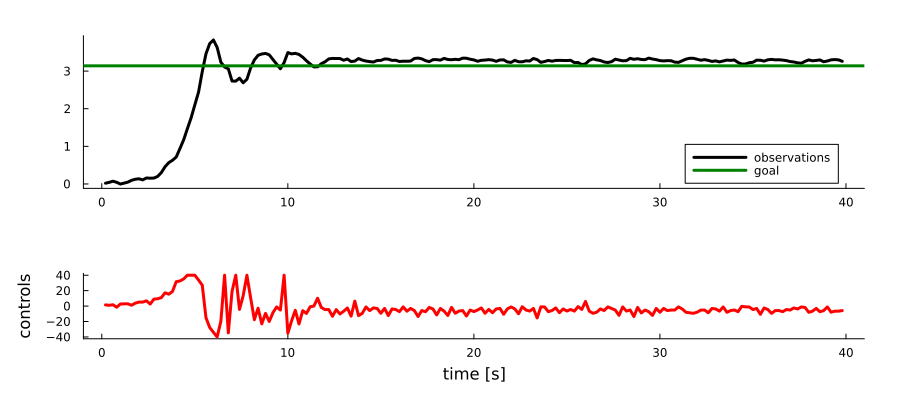

In [156]:
p1 = plot(tsteps[2:end], y_EFE[2:end], color="black", label="observations")
hline!([mean(goals[1])], color="green", label="goal")
# vline!([cut_gvar], color="orange", label="change in goal prior var")
p4 = plot(tsteps[2:end], u_EFE[2:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [157]:
savefig("figures/NARX-EFE-1Pendulum-trial.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-acquisition\\narx-efe\\notebooks\\figures\\NARX-EFE-1Pendulum-trial.png"

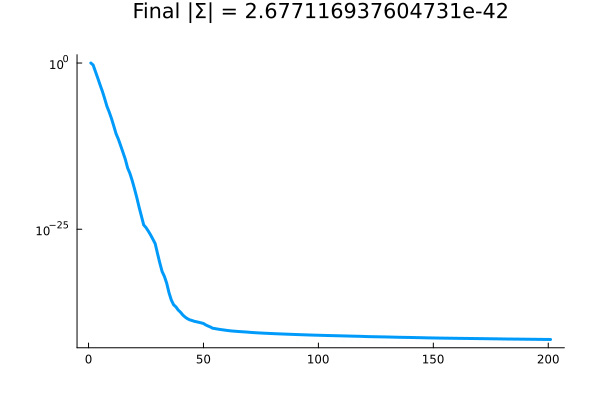

In [158]:
dSθ_EFE = det.(inv.(Λ_EFE))
final_dSθ_EFE = dSθ_EFE[end]
plot(dSθ_EFE, title="Final |Σ| = $final_dSθ_EFE", yscale=:log10)

┌ Info: Saved animation to c:\Syndr\Wouter\Onderzoek\Projecten\tue\efe-acquisition\narx-efe\notebooks\figures\NARX-EFE-1Pendulum-planning.gif
└ @ Plots C:\Users\Wouter Kouw\.julia\packages\Plots\QWCV6\src\animation.jl:156


Plots.AnimatedGif("c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-acquisition\\narx-efe\\notebooks\\figures\\NARX-EFE-1Pendulum-planning.gif")
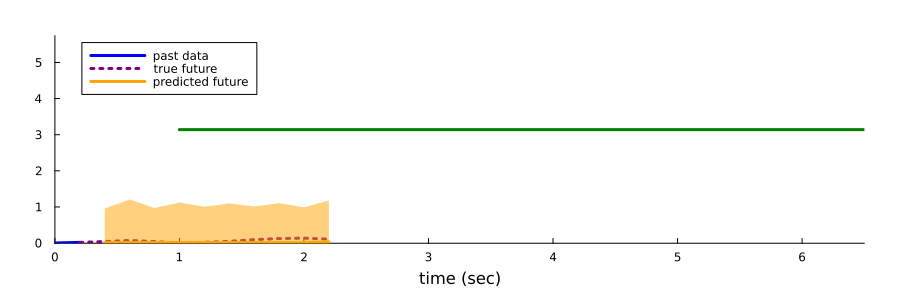

In [159]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        plot!(mean.(goals), color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        plot!(mean.(goals), color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-1Pendulum-planning.gif", fps=24)

### Mean Squared Error minimization

In [298]:
T = 10

# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T)

# Preallocate
y_MSE = zeros(N)
z_MSE = zeros(2,N)
u_MSE = zeros(N+T)
μ_MSE = [μ0]
Λ_MSE = [Λ0]
α_MSE = [α0]
β_MSE = [β0]
F_MSE = zeros(N)
pred_m = zeros(N,T)
pred_v = zeros(N,T)
goals = [Normal(3.14, 1.0) for t in 1:T]
# gvars = 10 .^range(3, stop=-3, length=N)
# gvars = [1e3 for k in 1:N]

@showprogress for k in 1:N    
    
    # Update parameter beliefs
    y_MSE[k] = pendulum.sensor
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    F_MSE[k] = agent.free_energy
    push!(μ_MSE, agent.μ )
    push!(Λ_MSE, agent.Λ )
    push!(α_MSE, agent.α )
    push!(β_MSE, agent.β )

    # # Move goal closer
    # goal_k = NormalMeanVariance(3.14, gvars[k])
    # update_goals!(goals, goal_k)
    # agent.goals = goals
    
    # Optimal control
    policy = minimizeMSE(agent, goals, control_lims=sys_ulims)
    u_MSE[k+1:k+T] = policy
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)

    # Act upon environment
    step!(pendulum, u_MSE[k+1])
    z_MSE[:,k] = pendulum.state
    
end

Progress:   4%|██                                       |  ETA: 0:00:03

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Wouter Kouw\.julia\packages\LineSearches\G1LRk\src\hagerzhang.jl:148


┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Wouter Kouw\.julia\packages\LineSearches\G1LRk\src\hagerzhang.jl:148
Progress:   6%|███                                      |  ETA: 0:00:25

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Wouter Kouw\.julia\packages\LineSearches\G1LRk\src\hagerzhang.jl:148
Progress:   7%|███                                      |  ETA: 0:00:31

Progress:   8%|████                                     |  ETA: 0:00:35

Progress:   8%|████                                     |  ETA: 0:00:34

Progress:   8%|████                                     |  ETA: 0:00:33

Progress:  10%|████                                     |  ETA: 0:00:32

Progress:  10%|█████                                    |  ETA: 0:00:31

Progress:  11%|█████                                    |  ETA: 0:00:31

Progress:  12%|█████                                    |  ETA: 0:00:32

Progress:  12%|██████                                   |  ETA: 0:00:40

Progress:  13%|██████                                   |  ETA: 0:00:41

Progress:  14%|██████                                   |  ETA: 0:00:47

Progress:  14%|██████                                   |  ETA: 0:00:55

Progress:  14%|██████                                   |  ETA: 0:00:55

Progress:  15%|███████                                  |  ETA: 0:00:56

Progress:  16%|███████                                  |  ETA: 0:00:59

Progress:  16%|███████                                  |  ETA: 0:00:58

Progress:  16%|███████                                  |  ETA: 0:00:57

Progress:  17%|███████                                  |  ETA: 0:01:19

Progress:  18%|████████                                 |  ETA: 0:01:17

Progress:  18%|████████                                 |  ETA: 0:01:13

Progress:  19%|████████                                 |  ETA: 0:01:11

Progress:  20%|████████                                 |  ETA: 0:01:10

Progress:  20%|█████████                                |  ETA: 0:01:12

Progress:  21%|█████████                                |  ETA: 0:01:08

Progress:  22%|██████████                               |  ETA: 0:01:06

Progress:  23%|██████████                               |  ETA: 0:01:02

Progress:  24%|██████████                               |  ETA: 0:00:59

Progress:  25%|███████████                              |  ETA: 0:00:57

Progress:  26%|███████████                              |  ETA: 0:00:53

Progress:  28%|████████████                             |  ETA: 0:00:49

Progress:  30%|█████████████                            |  ETA: 0:00:46

Progress:  31%|█████████████                            |  ETA: 0:00:43

Progress:  32%|██████████████                           |  ETA: 0:00:42

Progress:  32%|██████████████                           |  ETA: 0:00:41

Progress:  33%|██████████████                           |  ETA: 0:00:41

Progress:  34%|██████████████                           |  ETA: 0:00:40

Progress:  34%|███████████████                          |  ETA: 0:00:39

Progress:  36%|███████████████                          |  ETA: 0:00:36

Progress:  38%|████████████████                         |  ETA: 0:00:41

Progress:  39%|████████████████                         |  ETA: 0:00:41

Progress:  40%|█████████████████                        |  ETA: 0:00:40

Progress:  40%|█████████████████                        |  ETA: 0:00:39

Progress:  40%|█████████████████                        |  ETA: 0:00:39

Progress:  41%|█████████████████                        |  ETA: 0:00:38

Progress:  42%|██████████████████                       |  ETA: 0:00:38

Progress:  42%|██████████████████                       |  ETA: 0:00:36

Progress:  44%|██████████████████                       |  ETA: 0:00:35

Progress:  44%|███████████████████                      |  ETA: 0:00:35

Progress:  45%|███████████████████                      |  ETA: 0:00:34

Progress:  46%|███████████████████                      |  ETA: 0:00:35

Progress:  46%|███████████████████                      |  ETA: 0:00:34

Progress:  46%|████████████████████                     |  ETA: 0:00:34

Progress:  47%|████████████████████                     |  ETA: 0:00:34

Progress:  48%|████████████████████                     |  ETA: 0:00:33

Progress:  48%|████████████████████                     |  ETA: 0:00:36

Progress:  48%|████████████████████                     |  ETA: 0:00:35

Progress:  49%|█████████████████████                    |  ETA: 0:00:35

Progress:  50%|█████████████████████                    |  ETA: 0:00:34

Progress:  50%|█████████████████████                    |  ETA: 0:00:33

Progress:  50%|█████████████████████                    |  ETA: 0:00:33

Progress:  51%|█████████████████████                    |  ETA: 0:00:33

Progress:  52%|██████████████████████                   |  ETA: 0:00:32

Progress:  52%|██████████████████████                   |  ETA: 0:00:32

Progress:  53%|██████████████████████                   |  ETA: 0:00:31

Progress:  54%|██████████████████████                   |  ETA: 0:00:30

Progress:  54%|███████████████████████                  |  ETA: 0:00:30

Progress:  55%|███████████████████████                  |  ETA: 0:00:31

Progress:  56%|███████████████████████                  |  ETA: 0:00:31

Progress:  56%|███████████████████████                  |  ETA: 0:00:30

Progress:  56%|████████████████████████                 |  ETA: 0:00:30

Progress:  57%|████████████████████████                 |  ETA: 0:00:30

Progress:  58%|████████████████████████                 |  ETA: 0:00:29

Progress:  58%|████████████████████████                 |  ETA: 0:00:29

Progress:  58%|████████████████████████                 |  ETA: 0:00:28

Progress:  60%|█████████████████████████                |  ETA: 0:00:27

Progress:  60%|█████████████████████████                |  ETA: 0:00:27

Progress:  60%|█████████████████████████                |  ETA: 0:00:26

Progress:  61%|██████████████████████████               |  ETA: 0:00:26

Progress:  62%|██████████████████████████               |  ETA: 0:00:25

Progress:  62%|██████████████████████████               |  ETA: 0:00:25

Progress:  63%|██████████████████████████               |  ETA: 0:00:24

Progress:  64%|███████████████████████████              |  ETA: 0:00:24

Progress:  64%|███████████████████████████              |  ETA: 0:00:23

Progress:  65%|███████████████████████████              |  ETA: 0:00:22

Progress:  66%|███████████████████████████              |  ETA: 0:00:22

Progress:  66%|████████████████████████████             |  ETA: 0:00:22

Progress:  66%|████████████████████████████             |  ETA: 0:00:21

Progress:  68%|████████████████████████████             |  ETA: 0:00:20

Progress:  68%|████████████████████████████             |  ETA: 0:00:20

Progress:  68%|█████████████████████████████            |  ETA: 0:00:20

Progress:  70%|█████████████████████████████            |  ETA: 0:00:19

Progress:  70%|█████████████████████████████            |  ETA: 0:00:18

Progress:  72%|██████████████████████████████           |  ETA: 0:00:17

Progress:  72%|██████████████████████████████           |  ETA: 0:00:16

Progress:  74%|███████████████████████████████          |  ETA: 0:00:16

Progress:  74%|███████████████████████████████          |  ETA: 0:00:15

Progress:  76%|███████████████████████████████          |  ETA: 0:00:14

Progress:  76%|████████████████████████████████         |  ETA: 0:00:13

Progress:  78%|████████████████████████████████         |  ETA: 0:00:12

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:11

Progress:  81%|██████████████████████████████████       |  ETA: 0:00:10

Progress:  82%|██████████████████████████████████       |  ETA: 0:00:09

Progress:  84%|███████████████████████████████████      |  ETA: 0:00:08

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:08

Progress:  87%|████████████████████████████████████     |  ETA: 0:00:07

Progress:  88%|█████████████████████████████████████    |  ETA: 0:00:06

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:05

Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:04

Progress:  93%|███████████████████████████████████████  |  ETA: 0:00:03

Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:03

Progress:  96%|████████████████████████████████████████ |  ETA: 0:00:02

Progress:  98%|█████████████████████████████████████████|  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


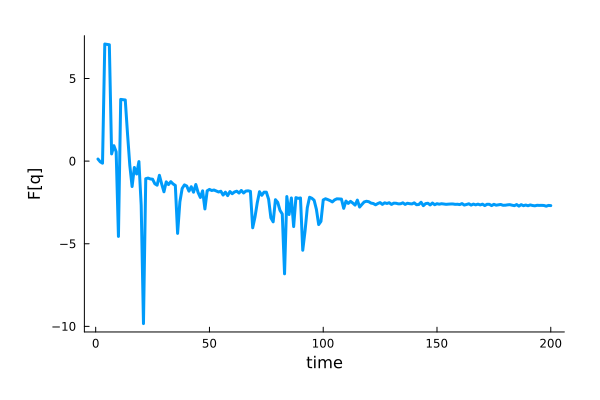

In [299]:
plot(F_MSE, xlabel="time", ylabel="F[q]")

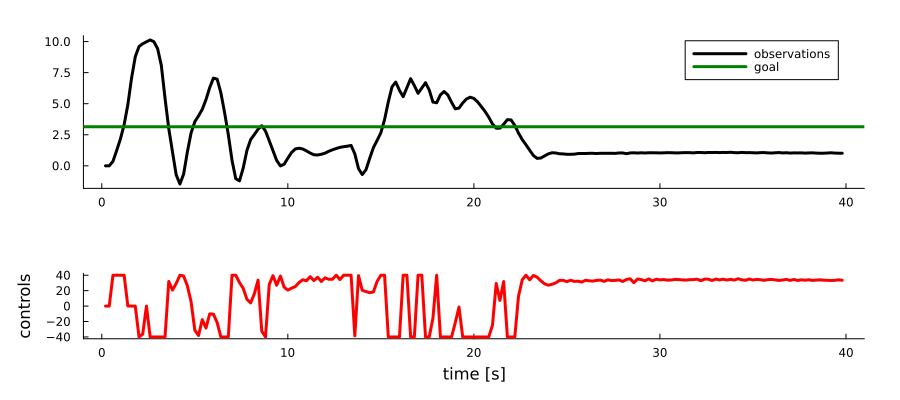

In [300]:
p1 = plot(tsteps[2:end], y_MSE[2:end], color="black", label="observations")
hline!([mean(goals[1])], color="green", label="goal")
p4 = plot(tsteps[2:end], u_MSE[2:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [301]:
savefig("figures/NARX-MSE-1Pendulum-trial.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-acquisition\\narx-efe\\notebooks\\figures\\NARX-MSE-1Pendulum-trial.png"

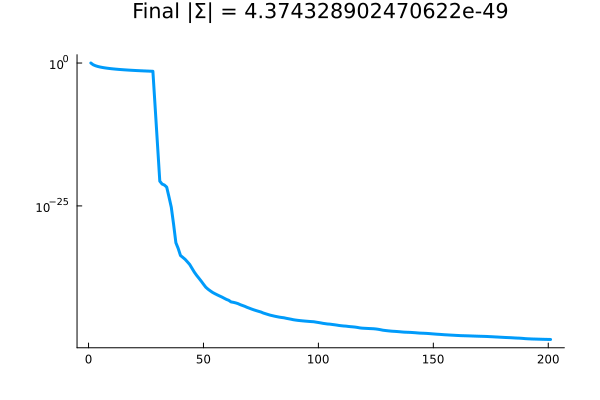

In [243]:
dSθ_MSE = det.(inv.(Λ_MSE))
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="Final |Σ| = $final_dSθ_MSE", yscale=:log10)

┌ Info: Saved animation to c:\Syndr\Wouter\Onderzoek\Projecten\tue\efe-acquisition\narx-efe\notebooks\figures\NARX-MSE-1Pendulum-planning.gif
└ @ Plots C:\Users\Wouter Kouw\.julia\packages\Plots\QWCV6\src\animation.jl:156


Plots.AnimatedGif("c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-acquisition\\narx-efe\\notebooks\\figures\\NARX-MSE-1Pendulum-planning.gif")
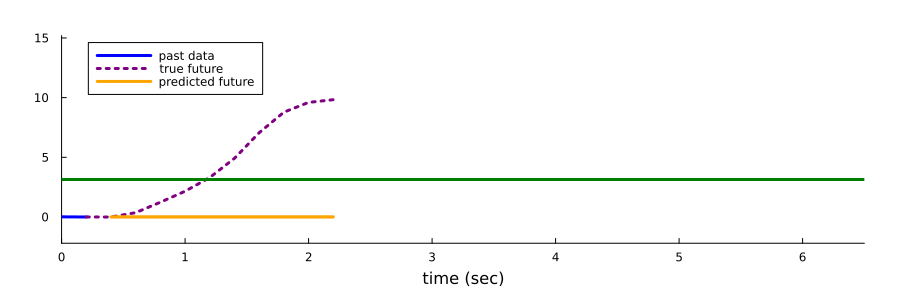

In [302]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-1Pendulum-planning.gif", fps=24)

### Comparisons

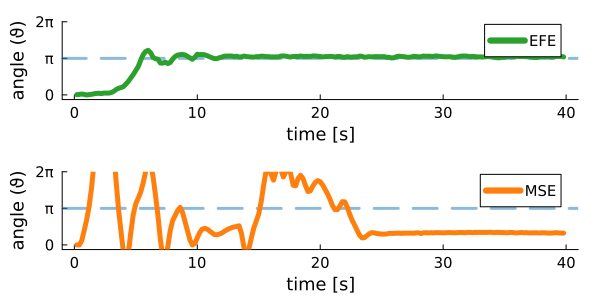

In [310]:
p1 = hline([mean(goals[1])], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5, ylims=(-.4, 2π), yticks=([0, 3.1415, 6.2830],[0, "π",  "2π"]), label="", xlabel="time [s]", ylabel="angle (ϑ)", guidefontsize=12, legendfontsize=10, tickfontsize=10)
plot!(tsteps[2:end], y_MSE[2:end], linewidth=5, color=palette(:tab10)[2], label="MSE")

p2 = hline([mean(goals[1])], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5, ylims=(-.4, 2π), yticks=([0, 3.1415, 6.2830],[0, "π",  "2π"]), label="", xlabel="time [s]", ylabel="angle (ϑ)", guidefontsize=12, legendfontsize=10, tickfontsize=10)
plot!(tsteps[2:end], y_EFE[2:end], linewidth=5, color=palette(:tab10)[3], label="EFE")
# vline!([cut_gvar], color="orange", label="change in goal prior var")
# p4 = plot(tsteps[2:end], u_EFE[2:end-T], color="red", ylabel="controls", )

plot(p2,p1, layout=grid(2,1, heights=[.5, .5]), size=(600,300), margin=10Plots.pt)

In [311]:
savefig("figures/compare-trials.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-acquisition\\narx-efe\\notebooks\\figures\\compare-trials.png"

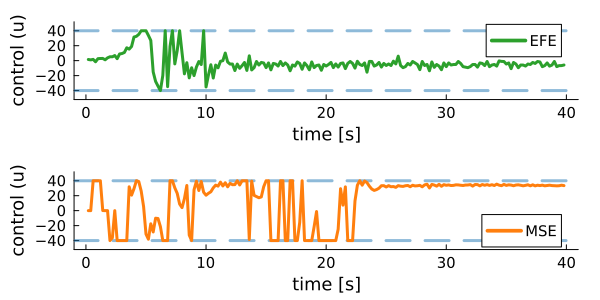

In [312]:
p1 = hline([sys_ulims[1]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
hline!([sys_ulims[2]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
plot!(tsteps[2:end], u_MSE[2:end-T], linewidth=3, color=palette(:tab10)[2], label="MSE", ylims=sys_ulims.*1.3, xlabel="time [s]", ylabel="control (u)", guidefontsize=12, legendfontsize=10, tickfontsize=10)

p2 = hline([sys_ulims[1]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
hline!([sys_ulims[2]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
plot!(tsteps[2:end], u_EFE[2:end-T], linewidth=3, color=palette(:tab10)[3], label="EFE", ylims=sys_ulims.*1.3, xlabel="time [s]", ylabel="control (u)", guidefontsize=12, legendfontsize=10, tickfontsize=10)

plot(p2,p1, layout=grid(2,1, heights=[.5, .5]), size=(600,300), margin=10Plots.pt)

In [313]:
savefig("figures/compare-controls.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-acquisition\\narx-efe\\notebooks\\figures\\compare-controls.png"

In [25]:
println("Final sum of eigenvalues of Σ_θ for MSE = $final_dSθ_MSE")
println("Final sum of eigenvalues of Σ_θ for EFE = $final_dSθ_EFE")

Final sum of eigenvalues of Σ_θ for MSE = 2.676317947734058e-38
Final sum of eigenvalues of Σ_θ for EFE = 8.962693515562022e-32


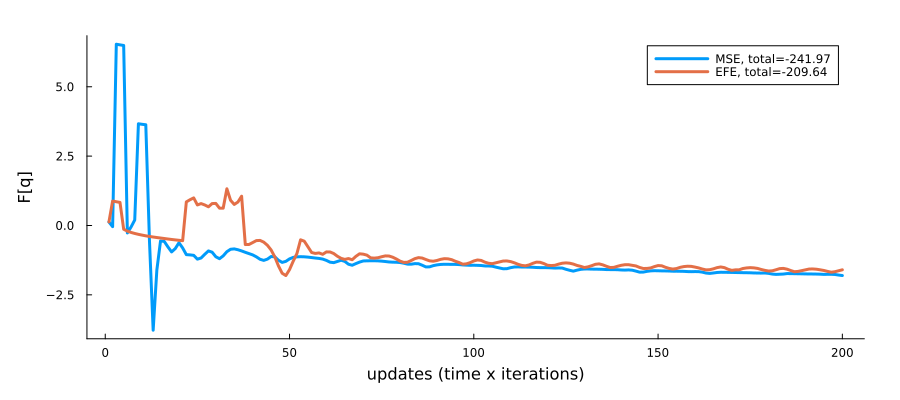

In [26]:
sF_MSE = round(sum(F_MSE[:]), digits=2)
sF_EFE = round(sum(F_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(F_MSE[:], label="MSE, total=$sF_MSE")
plot!(F_EFE[:], label="EFE, total=$sF_EFE")

In [27]:
# evidence_MSE = [-logpdf(py_MSE[k][1], y_MSE[k+1]) for k in 1:(N-1)]
# evidence_EFE = [-logpdf(py_EFE[k][1], y_EFE[k+1]) for k in 1:(N-1)]

# total_evidence_MSE = round(sum(evidence_MSE), digits=2)
# total_evidence_EFE = round(sum(evidence_EFE), digits=2)

# plot(xlabel="time (steps)", ylabel="-logp(y)", size=(900,400))
# plot!(evidence_MSE, label="MSE, total=$total_evidence_MSE")
# plot!(evidence_EFE, label="EFE, total=$total_evidence_EFE")

UndefVarError: UndefVarError: `py_MSE` not defined

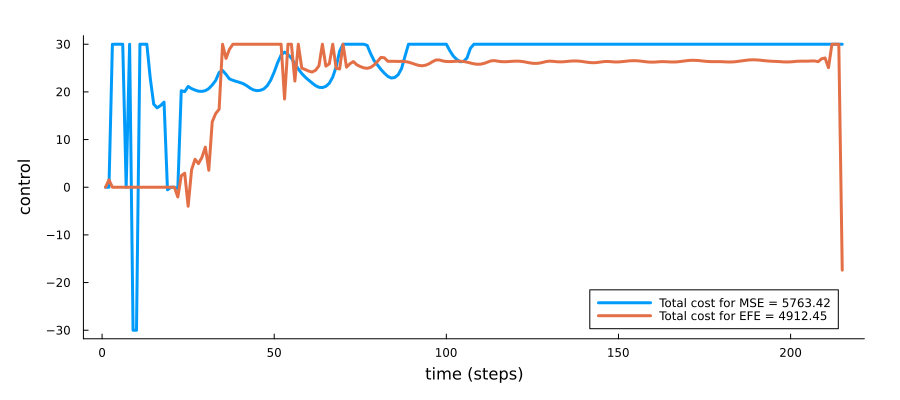

In [28]:
CC_MSE = round(sum(abs.(u_MSE)), digits=2)
CC_EFE = round(sum(abs.(u_EFE)), digits=2)

plot(xlabel="time (steps)", ylabel="control", size=(900,400))
plot!(u_MSE, label="Total cost for MSE = $CC_MSE")
plot!(u_EFE, label="Total cost for EFE = $CC_EFE")

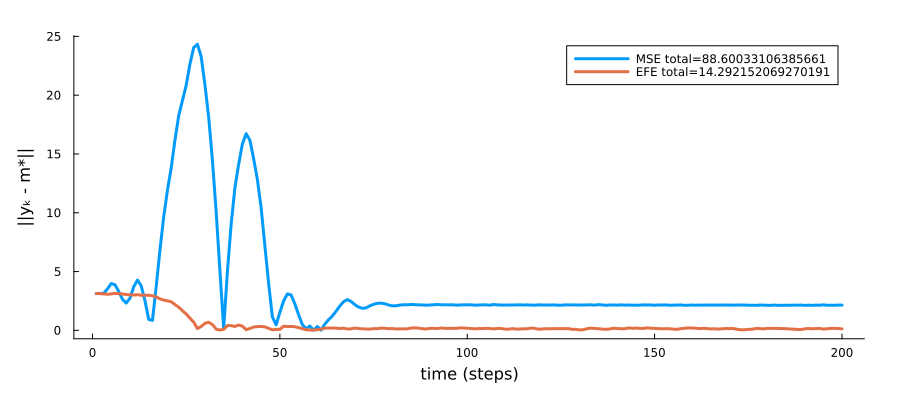

In [175]:
J_MSE = [norm(y_MSE[k] - mean(goals[1]),2) for k in 1:N]
J_EFE = [norm(y_EFE[k] - mean(goals[1]),2) for k in 1:N]

sJ_MSE = norm(y_MSE .- mean(goals[1]),2)
sJ_EFE = norm(y_EFE .- mean(goals[1]),2)

plot(xlabel="time (steps)", ylabel="||yₖ - m*||", size=(900,400))
plot!(J_MSE, label="MSE total=$sJ_MSE")
plot!(J_EFE, label="EFE total=$sJ_EFE")